In [28]:
%matplotlib inline
%config Completer.use_jedi = False # to use autocomplete
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
import json
import pandas as pd
import sklearn
from random import seed
from sklearn.model_selection import KFold
from sklearn import linear_model, ensemble, neighbors, tree
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
# from sklearn.preprocessing import PolynomialFeatures
# from texttable import Texttable
import scipy.optimize as optimization
RANDOM_SEED=0
seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
print(sklearn.__version__)
from itertools import combinations
from numpy.random import default_rng
import itertools
plt.rcdefaults()
# plt.rcParams.update({'font.family':'fantasy'})

0.24.2


In [29]:
def path_leaf(path): # get filename(with extension) from path
    head, tail = os.path.split(path)
    return tail or os.path.basename(head)


def file_in_folder(folder_path, flag=1): # get files in given folder, return list of filepath and filename
    file_list = []
    file_name = []
    for(dirpath, dirnames, filenames) in os.walk(folder_path):
#         print(filenames)
        
        for i in filenames:
            try:
                file_list += [dirpath + os.sep + i]
                file_name += [i]
            except:
                continue
        if flag == 0:
            break
        file_list.sort(key=path_leaf)
        file_name.sort()
    return [file_list, file_name]

In [30]:
res_dir = '../../prediction_code/5_mse_in_sample_lottery_transfer/in_sample'
all_folders = [os.path.join(res_dir, i) for i in os.listdir(res_dir)]

# get data

df = pd.read_csv('../../../data/PPP_normalized_pooled_data/30countries.csv')

a, b = np.unique(df['lottery'], return_counts=True)

useful_lottery_num = []
for i in range(b.shape[0]):
    if b[i] > 2900:
        useful_lottery_num.append(int(a[i]))
print(useful_lottery_num, len(useful_lottery_num))
# in total 24 lotteries
num_domains = len(useful_lottery_num)


all_params = ['a', 'b', 'd', 'g']
CPT_models = []
for i in range(1, len(all_params)+1):
    tmp = list(itertools.combinations(all_params, i))
    CPT_models += tmp
    
CPT_models = [''.join(i) for i in CPT_models]
CPT_models = ['g', 'ab', 'dg', 'abg', 'abdg']
# model_types = [model_types[-1]]
print(CPT_models)
ML_models = ['DT', 'RF', 'NN']
ML_models = ['Lasso', 'RF', 'NN']
ML_models = ['EU_iso', 'RF', 'kernel_ridge_rbf']
all_models = CPT_models + ML_models

[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 44] 24
['g', 'ab', 'dg', 'abg', 'abdg']


In [31]:
def get_in_sample(folder='../../prediction_code/mse_in_sample_lottery_transfer/in_sample'):
    in_sample_folders = os.listdir(folder)
    res = {}
    for cur_fol in in_sample_folders:
        file_list, file_name = file_in_folder(os.path.join(folder, cur_fol))
        file_list = [i for i in file_list if '.json' in i]
        file_name = [i for i in file_name if '.json' in i]
#         print(file_list)
        for file in file_list:
            with open(file, 'r') as f:
                content = json.load(f)
#             print(content)
            if cur_fol not in res.keys():
                res[cur_fol] = {}
#             print(file)
#             if '/EU' in file:
#                 tmp = 'EU'
#             else:
            tmp = content['model_type']
            if tmp == 'RF' or tmp == 'kernel_ridge_rbf':
                print(file)
            res[cur_fol][tmp] = content['train_mse']
    print(res)
    return res

In [32]:
in_sample_res = get_in_sample()

../../mse_in_sample_lottery_transfer/in_sample/32/RF.json
../../mse_in_sample_lottery_transfer/in_sample/32/kernel_ridge_rbf.json
../../mse_in_sample_lottery_transfer/in_sample/34/RF.json
../../mse_in_sample_lottery_transfer/in_sample/34/kernel_ridge_rbf.json
../../mse_in_sample_lottery_transfer/in_sample/33/RF.json
../../mse_in_sample_lottery_transfer/in_sample/33/kernel_ridge_rbf.json
../../mse_in_sample_lottery_transfer/in_sample/27/RF.json
../../mse_in_sample_lottery_transfer/in_sample/27/kernel_ridge_rbf.json
../../mse_in_sample_lottery_transfer/in_sample/9/RF.json
../../mse_in_sample_lottery_transfer/in_sample/9/kernel_ridge_rbf.json
../../mse_in_sample_lottery_transfer/in_sample/11/RF.json
../../mse_in_sample_lottery_transfer/in_sample/11/kernel_ridge_rbf.json
../../mse_in_sample_lottery_transfer/in_sample/7/RF.json
../../mse_in_sample_lottery_transfer/in_sample/7/kernel_ridge_rbf.json
../../mse_in_sample_lottery_transfer/in_sample/6/RF.json
../../mse_in_sample_lottery_transfer/

In [33]:
def get_round(a, digit=3):
    return round(a, digit)

def get_res(folder, normalize=False, in_sample_dic=None):
    file_list, file_name = file_in_folder(folder)
    file_list = [i for i in file_list if '.json' in i]
    file_name = [i for i in file_name if '.json' in i]
    print(file_list)
    res_dic = {'model': [], 'train_data': [], 'train_mse': []}
    train_data = folder.split('/')[1]
    for model_type in all_models:
        for file in file_list:
            file_type = path_leaf(file).split('.json')[0]
            if model_type == file_type:
                with open(file, 'r') as f:
                    content = json.load(f)
#                 print(content)
                res_dic['model'].append(content['model_type'])
                res_dic['train_data'].append(train_data)
                res_dic['train_mse'].append(get_round(content['train_mse']))
                for key, val in content['test_mse'].items():
                    if key not in res_dic.keys():
                        res_dic[key] = []
                    if normalize:
                        res_dic[key].append(get_round(val/in_sample_dic[key][model_type]))
                    else:
                        res_dic[key].append(get_round(val))

#     print(res_dic)
    df = pd.DataFrame.from_dict(res_dic)
    display(df)
    print(df.to_latex(index=False))
    return res_dic

In [34]:
print(len(in_sample_res.keys()))
list(in_sample_res.keys())[0]

24


'32'

In [35]:
all_content = {}
for folder in all_folders:
    file_list, file_name = file_in_folder(folder)
    file_list = [i for i in file_list if '.json' in i]
    file_name = [i for i in file_name if '.json' in i]
    for file in file_list:
        file_type = path_leaf(file).split('.json')[0]
        try:
            with open(file, 'r') as f:
                content = json.load(f)
        except:
            print(file)
        all_content[file] = content

In [36]:
# all_missing = {i: [] for i in CPT_models + ML_models}
# for folder in all_folders:
#     file_list, file_name = file_in_folder(folder)
#     file_list = [i for i in file_list if '.json' in i]
#     file_name = [i for i in file_name if '.json' in i]
#     for file in file_list:
#         file_type = path_leaf(file).split('.json')[0]
#         all_missing[file_type].append(int(folder))

In [37]:
def get_index(arr, median_of):
    # median_of is 'min', 'max', or percentile (50, 75, 90, etc.)
    if median_of == 'max':
        return np.argmax(arr)
    elif median_of == 'min':
        return np.argmin(arr)
    else:
        percent = int(median_of)
        interpolation = 'higher'
        if percent < 50:
            interpolation = 'lower'
        val = np.percentile(arr, percent, interpolation=interpolation)
#         if val in arr:
#             print(1, val)
#         else:
#             print(0, val)
#             print(arr)
        if type(arr) == np.ndarray:
            return np.where(arr == val)[0][0]
        else:
            return arr.index(val)

def get_percentile(arr, median_of):
    # median_of is 'min', 'max', or percentile (50, 75, 90, etc.)
    if median_of == 'max':
        return np.max(arr)
    elif median_of == 'min':
        return np.min(arr)
    else:
        percent = int(median_of)
        interpolation = 'higher'
        if percent < 50:
            interpolation = 'lower'
        val = np.percentile(arr, percent, interpolation=interpolation)
        return val

def get_median_transfer_error(folder_list, all_contents=None, normalize=False, in_sample_dic=None, use_best_in_sample=False, median_of='max', median_of_list=None, model_to_see=None):
    if use_best_in_sample:
        best_in_sample_across_model = {}
        for key, val in in_sample_dic.items():
            best_in_sample_across_model[key] = {}

            best_in_sample = 1e10
            for model_type, cur_error in val.items():
                if model_type not in model_to_see:
                    continue
                if best_in_sample > cur_error:
                    best_in_sample = cur_error
            for model_type in val.keys():
                if model_type not in model_to_see:
                    continue
                best_in_sample_across_model[key][model_type] = best_in_sample
    else:
        best_in_sample_across_model = in_sample_dic
    
        
#     print(best_in_sample_across_model)
#     res_dic = {'model': [], 'train_data': [], 'train_mse': []}
    res_dic = {}
    all_res_dic = {}
    count = 0
    for folder in folder_list:
#         if count > 0:
#             break
#         count += 1
        file_list, file_name = file_in_folder(folder)
        file_list = [i for i in file_list if '.json' in i]
        file_name = [i for i in file_name if '.json' in i]
#         print(file_list)
        
        train_data = folder.split('/')[1]
        for model_type in model_to_see:
            if model_type not in res_dic.keys():
                res_dic[model_type] = {'train_data': [], 'transfer_domain': [], 'in_sample': [], 
                                       'raw_transfer': [], 'best_in_sample': [], 'transfer_ratio': []}
                all_res_dic[model_type] = {'train_data': [], 'transfer_domain': [], 'in_sample': [], 
                                       'raw_transfer': [], 'best_in_sample': [], 'transfer_ratio': []}
            for file in file_list:
                file_type = path_leaf(file).split('.json')[0]
#                 print(file_type)
                if 'RF' in file_type or 'kernel_ridge_rbf' in file_type:
#                     print(file_type)
                    # if 'domain_cv' not in file_type:
                    #     continue
                    # else:
                    if 'checkpoint' in file:
                        continue
    #                 file_type = path_leaf(file).split('.json')[0]
                    try:
                        with open(file, 'r') as f:
                            content = json.load(f)
                        file_type = content['model_type']
                    except:
                        file_type = path_leaf(file).split('.json')[0]
#                 print(file)
#                 print(file_type)
                if model_type == file_type:
                    if all_contents is not None:
                        content = all_contents[file]
                    else:
                        with open(file, 'r') as f:
                            content = json.load(f)

                    all_transfer_domain = []
                    all_transfer_error_ratio = []
                    raw_transfer = []
                    in_sample = []
                    best_in_sample = []
                    for key, val in content['test_mse'].items():
                        all_transfer_domain.append(key)
                        raw_transfer.append(get_round(np.sqrt(val)))
                        in_sample.append(get_round(np.sqrt(in_sample_dic[key][model_type])))
                        best_in_sample.append(get_round(np.sqrt(best_in_sample_across_model[key][model_type])))
#                         all_transfer_error_ratio.append(get_round(best_in_sample_across_model[key][model_type]/val))
                        all_transfer_error_ratio.append(get_round(np.sqrt(val)/np.sqrt(best_in_sample_across_model[key][model_type])))
#                         if normalize:
#                             all_transfer_error_ratio.append(get_round(best_in_sample_across_model[key][model_type]/val))
#                         else:
#                             all_transfer_error_ratio.append(get_round(val))
                    
#                     print(len(all_transfer_domain))
                    if normalize:
                        list_to_find_index = all_transfer_error_ratio
                    else:
                        list_to_find_index = raw_transfer
#                     best_idx = np.argmax(raw_transfer)
                    best_idx = get_index(list_to_find_index, median_of=median_of)
#                     print(best_idx)
                    res_dic[model_type]['train_data'].append(train_data)
                    res_dic[model_type]['transfer_ratio'].append(all_transfer_error_ratio[best_idx])
                    res_dic[model_type]['transfer_domain'].append(all_transfer_domain[best_idx])
                    res_dic[model_type]['raw_transfer'].append(raw_transfer[best_idx])
                    res_dic[model_type]['in_sample'].append(in_sample[best_idx])
                    res_dic[model_type]['best_in_sample'].append(best_in_sample[best_idx])
                    
                    all_res_dic[model_type]['train_data'].append([train_data]*len(all_transfer_error_ratio))
                    all_res_dic[model_type]['transfer_ratio'].append(all_transfer_error_ratio)
                    all_res_dic[model_type]['transfer_domain'].append(all_transfer_domain)
                    all_res_dic[model_type]['raw_transfer'].append(raw_transfer)
                    all_res_dic[model_type]['in_sample'].append(in_sample)
                    all_res_dic[model_type]['best_in_sample'].append(best_in_sample)
    
    # for key, val in all_res_dic.items():
    #     print(key, val['train_data'])
    final_return = {}
    for median_of in median_of_list:
        print(median_of)
        res_dic = {}
        for model_type in model_to_see:
            if model_type not in res_dic.keys():
                res_dic[model_type] = {'train_data': [], 'transfer_domain': [], 'in_sample': [], 
                                       'raw_transfer': [], 'best_in_sample': [], 'transfer_ratio': []}
            
#             for i in range(len(all_res_dic[model_type]['train_data'])):
            train_data = all_res_dic[model_type]['train_data'][0][0]
            all_transfer_domain = np.array(all_res_dic[model_type]['transfer_domain']).reshape(-1,)
            all_transfer_error_ratio = np.array(all_res_dic[model_type]['transfer_ratio']).reshape(-1,)
            raw_transfer = np.array(all_res_dic[model_type]['raw_transfer']).reshape(-1,)
            in_sample = np.array(all_res_dic[model_type]['in_sample']).reshape(-1,)
            best_in_sample = np.array(all_res_dic[model_type]['best_in_sample']).reshape(-1,)
#             print(all_transfer_domain.shape, all_transfer_error_ratio.shape, raw_transfer.shape, in_sample.shape, best_in_sample.shape)

            if normalize:
                list_to_find_index = all_transfer_error_ratio
            else:
                list_to_find_index = raw_transfer

            best_idx = get_index(list_to_find_index, median_of=median_of)

            res_dic[model_type]['train_data'].append(train_data)
            res_dic[model_type]['transfer_ratio'].append(all_transfer_error_ratio[best_idx])
            res_dic[model_type]['transfer_domain'].append(all_transfer_domain[best_idx])
            res_dic[model_type]['raw_transfer'].append(raw_transfer[best_idx])
            res_dic[model_type]['in_sample'].append(in_sample[best_idx])
            res_dic[model_type]['best_in_sample'].append(best_in_sample[best_idx])
            
            
            
        if normalize:
            sort_key = 'transfer_ratio'
        else:
            sort_key = 'raw_transfer'
        final_res = {'model': [], 'train_data': [], 'transfer_domain': [], 'in_sample': [], 'raw_transfer': [], 
                     'best_in_sample': [], 'transfer_ratio': []}
        only_median_res = {'model': [], 'median_transfer_error': []}
        for key, val in res_dic.items():
#             print(key)
            df = pd.DataFrame.from_dict(val)
#             print(df.shape)
#             display(df)
            final_res['model'].append(key)
            final_res['train_data'].append(df['train_data'].values[0])
            final_res['transfer_domain'].append(df['transfer_domain'].values[0])
            final_res['transfer_ratio'].append(df['transfer_ratio'].values[0])
            final_res['raw_transfer'].append(df['raw_transfer'].values[0])
            final_res['in_sample'].append(df['in_sample'].values[0])
            final_res['best_in_sample'].append(df['best_in_sample'].values[0])

        final_return[median_of] = final_res[sort_key]
#     return final_res[sort_key]
    return final_return

## For each training domain, find the specific transfer error.  Then report the median of the specific transfer errors, across training domains.

In [38]:
%%time
raw_transfer_dic = {}
median_of_list = ['max', 95, 90, 75, 50, 25, 10, 5, 'min']

raw_transfer_dic = get_median_transfer_error(all_folders, all_contents=all_content, normalize=False, in_sample_dic=in_sample_res, use_best_in_sample=False, median_of_list=median_of_list, model_to_see=CPT_models+ML_models)

max
95
90
75
50
25
10
5
min
CPU times: user 3min 5s, sys: 27.7 s, total: 3min 33s
Wall time: 3min 59s


## For each training domain, find the MAX ratio normalized by best IN SAMPLE of ALL MODELS. Then report the median of the max ratios, across training domains.

In [39]:
%%time
best_normalize_dic = {}

best_normalize_dic = get_median_transfer_error(all_folders, all_contents=all_content, normalize=True, 
                                               in_sample_dic=in_sample_res, use_best_in_sample=True, median_of_list=median_of_list, model_to_see=CPT_models+ML_models)

max
95
90
75
50
25
10
5
min
CPU times: user 2min 56s, sys: 17.8 s, total: 3min 14s
Wall time: 3min 32s


## For each training domain, find the MAX ratio normalized by MODEL IN SAMPLE. Then report the median of the max ratios, across training domains.

In [40]:
%%time
same_model_normalize_dic = {}

same_model_normalize_dic = get_median_transfer_error(all_folders, all_contents=all_content, normalize=True, 
                                                     in_sample_dic=in_sample_res, use_best_in_sample=False, median_of_list=median_of_list, model_to_see=CPT_models+ML_models)

max
95
90
75
50
25
10
5
min
CPU times: user 2min 56s, sys: 19 s, total: 3min 15s
Wall time: 3min 33s


# make tables

In [41]:
def make_tables(model, data, median_of_list):
    res = {'model': model}
    for median_of in median_of_list:
        res[median_of] = data[median_of]
#     res[f'lower_{lower_percent}'] = data[lower_percent]
#     res[f'higher_{higher_percent}'] = data[higher_percent]

    df = pd.DataFrame.from_dict(res)
    display(df)
    print(df.to_latex(index=False))
#     return res

In [42]:
make_tables(all_models, raw_transfer_dic, median_of_list)
make_tables(all_models, best_normalize_dic, median_of_list)
make_tables(all_models, same_model_normalize_dic, median_of_list)

,model,max,95,90,75,50,25,10,5,min
0,g,5.312,5.098,4.913,4.662,4.302,3.154,1.858,1.134,1.034
1,ab,16.180,5.625,5.311,5.046,4.461,3.453,1.880,1.134,1.034
2,dg,8.025,5.193,4.975,4.682,4.295,3.234,1.896,1.144,0.986
3,abg,16.180,5.312,5.218,4.763,4.336,3.485,1.906,1.136,1.034
4,abdg,16.655,5.931,5.229,4.787,4.417,3.552,1.913,1.142,0.968
5,EU_iso,7.442,5.234,5.174,4.882,4.396,3.154,1.844,1.134,0.968
6,RF,39.701,14.757,11.365,7.947,5.704,4.736,4.175,3.217,0.968
7,kernel_ridge_rbf,35.832,13.262,10.371,7.209,5.310,4.301,2.502,1.870,0.968


\begin{tabular}{lrrrrrrrrr}
\toprule
           model &    max &     95 &     90 &    75 &    50 &    25 &    10 &     5 &   min \\
\midrule
               g &  5.312 &  5.098 &  4.913 & 4.662 & 4.302 & 3.154 & 1.858 & 1.134 & 1.034 \\
              ab & 16.180 &  5.625 &  5.311 & 5.046 & 4.461 & 3.453 & 1.880 & 1.134 & 1.034 \\
              dg &  8.025 &  5.193 &  4.975 & 4.682 & 4.295 & 3.234 & 1.896 & 1.144 & 0.986 \\
             abg & 16.180 &  5.312 &  5.218 & 4.763 & 4.336 & 3.485 & 1.906 & 1.136 & 1.034 \\
            abdg & 16.655 &  5.931 &  5.229 & 4.787 & 4.417 & 3.552 & 1.913 & 1.142 & 0.968 \\
          EU\_iso &  7.442 &  5.234 &  5.174 & 4.882 & 4.396 & 3.154 & 1.844 & 1.134 & 0.968 \\
              RF & 39.701 & 14.757 & 11.365 & 7.947 & 5.704 & 4.736 & 4.175 & 3.217 & 0.968 \\
kernel\_ridge\_rbf & 35.832 & 13.262 & 10.371 & 7.209 & 5.310 & 4.301 & 2.502 & 1.870 & 0.968 \\
\bottomrule
\end{tabular}



,model,max,95,90,75,50,25,10,5,min
0,g,1.155,1.068,1.055,1.028,1.010,1.004,1.000,1.000,1.0
1,ab,3.451,1.331,1.186,1.083,1.038,1.010,1.002,1.001,1.0
2,dg,1.688,1.084,1.055,1.029,1.012,1.002,1.000,1.000,1.0
3,abg,3.451,1.220,1.105,1.042,1.015,1.003,1.001,1.000,1.0
4,abdg,3.551,1.493,1.154,1.051,1.017,1.003,1.000,1.000,1.0
5,EU_iso,1.563,1.104,1.082,1.049,1.019,1.004,1.001,1.000,1.0
6,RF,19.118,6.193,4.547,2.433,1.456,1.110,1.044,1.016,1.0
7,kernel_ridge_rbf,15.851,3.545,2.755,1.835,1.336,1.074,1.011,1.003,1.0


\begin{tabular}{lrrrrrrrrr}
\toprule
           model &    max &    95 &    90 &    75 &    50 &    25 &    10 &     5 &  min \\
\midrule
               g &  1.155 & 1.068 & 1.055 & 1.028 & 1.010 & 1.004 & 1.000 & 1.000 &  1.0 \\
              ab &  3.451 & 1.331 & 1.186 & 1.083 & 1.038 & 1.010 & 1.002 & 1.001 &  1.0 \\
              dg &  1.688 & 1.084 & 1.055 & 1.029 & 1.012 & 1.002 & 1.000 & 1.000 &  1.0 \\
             abg &  3.451 & 1.220 & 1.105 & 1.042 & 1.015 & 1.003 & 1.001 & 1.000 &  1.0 \\
            abdg &  3.551 & 1.493 & 1.154 & 1.051 & 1.017 & 1.003 & 1.000 & 1.000 &  1.0 \\
          EU\_iso &  1.563 & 1.104 & 1.082 & 1.049 & 1.019 & 1.004 & 1.001 & 1.000 &  1.0 \\
              RF & 19.118 & 6.193 & 4.547 & 2.433 & 1.456 & 1.110 & 1.044 & 1.016 &  1.0 \\
kernel\_ridge\_rbf & 15.851 & 3.545 & 2.755 & 1.835 & 1.336 & 1.074 & 1.011 & 1.003 &  1.0 \\
\bottomrule
\end{tabular}



,model,max,95,90,75,50,25,10,5,min
0,g,1.155,1.035,1.022,1.008,1.000,1.000,1.000,1.000,1.0
1,ab,3.451,1.266,1.115,1.066,1.028,1.002,1.000,1.000,1.0
2,dg,1.688,1.084,1.055,1.029,1.012,1.002,1.000,1.000,1.0
3,abg,3.451,1.213,1.079,1.039,1.012,1.002,1.000,1.000,1.0
4,abdg,3.551,1.493,1.154,1.051,1.017,1.003,1.000,1.000,1.0
5,EU_iso,1.563,1.086,1.071,1.044,1.018,1.004,1.001,1.000,1.0
6,RF,19.118,6.193,4.547,2.433,1.456,1.110,1.044,1.016,1.0
7,kernel_ridge_rbf,15.851,3.545,2.755,1.835,1.336,1.074,1.011,1.003,1.0


\begin{tabular}{lrrrrrrrrr}
\toprule
           model &    max &    95 &    90 &    75 &    50 &    25 &    10 &     5 &  min \\
\midrule
               g &  1.155 & 1.035 & 1.022 & 1.008 & 1.000 & 1.000 & 1.000 & 1.000 &  1.0 \\
              ab &  3.451 & 1.266 & 1.115 & 1.066 & 1.028 & 1.002 & 1.000 & 1.000 &  1.0 \\
              dg &  1.688 & 1.084 & 1.055 & 1.029 & 1.012 & 1.002 & 1.000 & 1.000 &  1.0 \\
             abg &  3.451 & 1.213 & 1.079 & 1.039 & 1.012 & 1.002 & 1.000 & 1.000 &  1.0 \\
            abdg &  3.551 & 1.493 & 1.154 & 1.051 & 1.017 & 1.003 & 1.000 & 1.000 &  1.0 \\
          EU\_iso &  1.563 & 1.086 & 1.071 & 1.044 & 1.018 & 1.004 & 1.001 & 1.000 &  1.0 \\
              RF & 19.118 & 6.193 & 4.547 & 2.433 & 1.456 & 1.110 & 1.044 & 1.016 &  1.0 \\
kernel\_ridge\_rbf & 15.851 & 3.545 & 2.755 & 1.835 & 1.336 & 1.074 & 1.011 & 1.003 &  1.0 \\
\bottomrule
\end{tabular}



# percentile condifence interval result

In [43]:
def calculate_interval(model, data, lower_percent, higher_percent, m=44, k=1):
    res = {'model': [], f'lower_{lower_percent}': [], f'higher_{higher_percent}': [], 'RHS': []}
    res['model'] = model
    res[f'lower_{lower_percent}'] = data[lower_percent]
    res[f'higher_{higher_percent}'] = data[higher_percent]
#     res['RHS'] = [(2 * (res['higher'][i] - res['lower'][i])) / (m - k + 1) for i in range(len(res['lower']))]
    res['RHS'] = [
        (2 * (np.ceil(higher_percent/100 * (m-k)) - np.floor(lower_percent/100 * (m-k)))) / (m - k + 1) 
        for i in range(len(res[f'lower_{lower_percent}']))]
    df = pd.DataFrame.from_dict(res)
    display(df)
    print(df.to_latex(index=False))
    return res

In [44]:
# raw_transfer_dic
# best_normalize_dic
# same_model_normalize_dic
raw_transfer_interval = calculate_interval(all_models, raw_transfer_dic, lower_percent=10, higher_percent=90)

,model,lower_10,higher_90,RHS
0,g,1.858,4.913,1.590909
1,ab,1.880,5.311,1.590909
2,dg,1.896,4.975,1.590909
3,abg,1.906,5.218,1.590909
4,abdg,1.913,5.229,1.590909
5,EU_iso,1.844,5.174,1.590909
6,RF,4.175,11.365,1.590909
7,kernel_ridge_rbf,2.502,10.371,1.590909


\begin{tabular}{lrrr}
\toprule
           model &  lower\_10 &  higher\_90 &      RHS \\
\midrule
               g &     1.858 &      4.913 & 1.590909 \\
              ab &     1.880 &      5.311 & 1.590909 \\
              dg &     1.896 &      4.975 & 1.590909 \\
             abg &     1.906 &      5.218 & 1.590909 \\
            abdg &     1.913 &      5.229 & 1.590909 \\
          EU\_iso &     1.844 &      5.174 & 1.590909 \\
              RF &     4.175 &     11.365 & 1.590909 \\
kernel\_ridge\_rbf &     2.502 &     10.371 & 1.590909 \\
\bottomrule
\end{tabular}



In [45]:
best_normalize_interval = calculate_interval(all_models, best_normalize_dic, lower_percent=10, higher_percent=90)

,model,lower_10,higher_90,RHS
0,g,1.000,1.055,1.590909
1,ab,1.002,1.186,1.590909
2,dg,1.000,1.055,1.590909
3,abg,1.001,1.105,1.590909
4,abdg,1.000,1.154,1.590909
5,EU_iso,1.001,1.082,1.590909
6,RF,1.044,4.547,1.590909
7,kernel_ridge_rbf,1.011,2.755,1.590909


\begin{tabular}{lrrr}
\toprule
           model &  lower\_10 &  higher\_90 &      RHS \\
\midrule
               g &     1.000 &      1.055 & 1.590909 \\
              ab &     1.002 &      1.186 & 1.590909 \\
              dg &     1.000 &      1.055 & 1.590909 \\
             abg &     1.001 &      1.105 & 1.590909 \\
            abdg &     1.000 &      1.154 & 1.590909 \\
          EU\_iso &     1.001 &      1.082 & 1.590909 \\
              RF &     1.044 &      4.547 & 1.590909 \\
kernel\_ridge\_rbf &     1.011 &      2.755 & 1.590909 \\
\bottomrule
\end{tabular}



In [46]:
same_model_interval = calculate_interval(all_models, same_model_normalize_dic, lower_percent=10, higher_percent=90)

,model,lower_10,higher_90,RHS
0,g,1.000,1.022,1.590909
1,ab,1.000,1.115,1.590909
2,dg,1.000,1.055,1.590909
3,abg,1.000,1.079,1.590909
4,abdg,1.000,1.154,1.590909
5,EU_iso,1.001,1.071,1.590909
6,RF,1.044,4.547,1.590909
7,kernel_ridge_rbf,1.011,2.755,1.590909


\begin{tabular}{lrrr}
\toprule
           model &  lower\_10 &  higher\_90 &      RHS \\
\midrule
               g &     1.000 &      1.022 & 1.590909 \\
              ab &     1.000 &      1.115 & 1.590909 \\
              dg &     1.000 &      1.055 & 1.590909 \\
             abg &     1.000 &      1.079 & 1.590909 \\
            abdg &     1.000 &      1.154 & 1.590909 \\
          EU\_iso &     1.001 &      1.071 & 1.590909 \\
              RF &     1.044 &      4.547 & 1.590909 \\
kernel\_ridge\_rbf &     1.011 &      2.755 & 1.590909 \\
\bottomrule
\end{tabular}



# plot intervals

In [47]:
color_dic = {'g': 'tab:blue', 'ab': 'tab:orange', 'dg': 'tab:green', 'abg': 'tab:red', 'abdg': 'tab:purple', 
           'RF': 'tab:brown', 'Random Forest': 'tab:brown', 'kernel_ridge_rbf': 'tab:pink', 'EU_iso': 'tab:gray'
          }
def change_to_greek(models):
    dic = {'g': r'$\gamma$', 'ab': r'$\alpha\beta$', 'dg': r'$\delta\gamma$', 
           'abg': r'$\alpha\beta\gamma$', 'abdg': r'$\alpha\beta\delta\gamma$', 
           'RF': 'RF', 'NN': 'NN', 'Random Forest': 'RF', 'Neural Net': 'NN', 
           'kernel_ridge_poly': 'OLS-poly', 'kernel_ridge_rbf': 'KR', 'EU_expo': 'EU-CARA', 'EU_iso': 'EU'
          }
    
    res = []
    for i in models:
        res.append(dic[i])
    return res

def plot_intervals(model, data, lower_percent, higher_percent, keyword='Errors', capwidth=0.2, x_scale=None, savepath=None):
    lw = 2.5
    res = {'model': [], f'lower': [], f'higher': [], 'RHS': []}
    res['model'] = model
    res[f'lower'] = data[lower_percent]
    res[f'higher'] = data[higher_percent]
    count = 0
    for i in range(len(res['lower'])):
        if all_models[i] not in model:
            continue
        x = np.linspace(res['lower'][i], res['higher'][i], 100)
        y = [len(model)-1-count]*100
#         plt.plot(x, y, linewidth=10)
        plt.plot(x, y, lw=lw)
        
        bar_x = [x[0]]*100
        bar_y = np.linspace(y[0]-capwidth/2, y[0]+capwidth/2, 100)
        plt.plot(bar_x, bar_y, color='k', lw=lw)
        bar_x = [x[-1]]*100
        bar_y = np.linspace(y[-1]-capwidth/2, y[-1]+capwidth/2, 100)
        plt.plot(bar_x, bar_y, color='k', lw=lw)
        count += 1
        
    
#     plt.caption(f'{keyword} from {lower_percent}-percentile to {higher_percent}-percentile')
    plt.xlabel(f'{keyword}')
    plt.ylabel(f'Models')
    plt.yticks(range(len(model)), change_to_greek(reversed(model)))
    if x_scale == 'log':
        plt.xscale('log')
#     savepath=None
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()


def plot_intervals(model, data, lower_percent, higher_percent, keyword='Errors', capwidth=0.2, x_scale=None, savepath=None):
    lw = 2.5
    res = {'model': [], f'lower': [], f'higher': [], 'RHS': []}
    res['model'] = model
    res[f'lower'] = data[lower_percent]
    res[f'higher'] = data[higher_percent]
    count = 0
    plot_dic = {}
    for i in range(len(res['lower'])):
        if all_models[i] not in model:
            continue
        x = np.linspace(res['lower'][i], res['higher'][i], 100)
        y = [len(model)-1-count]*100
#         plt.plot(x, y, linewidth=10)
        plot_dic[res['higher'][i] - res['lower'][i]] = {'x': x, 'y': y, 'model': res['model'][i]}
    
    model_order = []
    for key in sorted(plot_dic.keys()):
        x = plot_dic[key]['x']
        y = [len(model)-1-count]*100
        model_order.append(plot_dic[key]['model'])
        plt.plot(x, y, lw=lw, color=color_dic[plot_dic[key]['model']])
        
        bar_x = [x[0]]*100
        bar_y = np.linspace(y[0]-capwidth/2, y[0]+capwidth/2, 100)
        plt.plot(bar_x, bar_y, color='k', lw=lw)
        bar_x = [x[-1]]*100
        bar_y = np.linspace(y[-1]-capwidth/2, y[-1]+capwidth/2, 100)
        plt.plot(bar_x, bar_y, color='k', lw=lw)
        count += 1
        
    
#     plt.caption(f'{keyword} from {lower_percent}-percentile to {higher_percent}-percentile')
    plt.xlabel(f'{keyword}')
    plt.ylabel(f'Models')
    if x_scale == 'log':
        plt.xscale('log')
    plt.yticks(range(len(model_order)), change_to_greek(reversed(model_order)))
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()

## 9-95 percentile

In [48]:
plt.rcdefaults()
plt.rcParams.update({'font.size':18})
plt.rcParams.update({'font.family':'Times New Roman'})
plt.rc('text', usetex=True)
lower_percent = 5
higher_percent = 95
transfer_error = 'Transfer error'
normalized_transfer = 'Normalized transfer error'
same_model_transfer = 'Transfer deterioration'
transfer_error = 'Raw transfer error'
normalized_transfer = 'Transfer shortfall'
same_model_transfer = 'Transfer deterioration'
# fol = '../stack_figures/to_stack'
fol = '.'

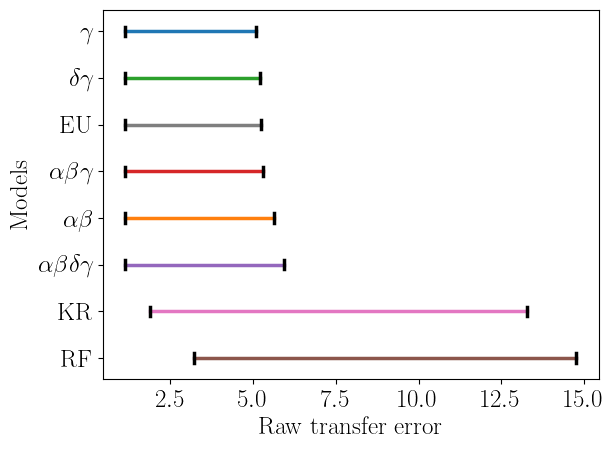

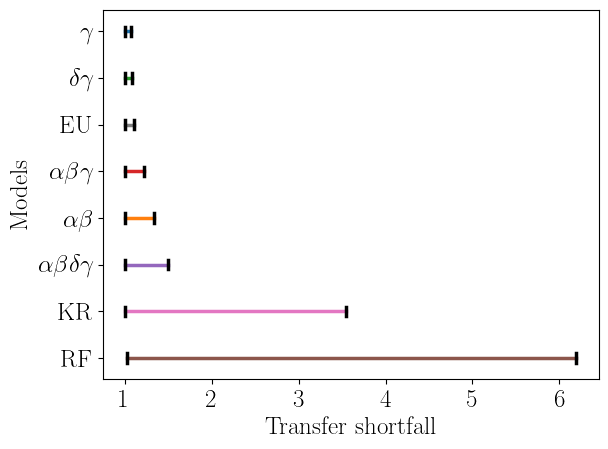

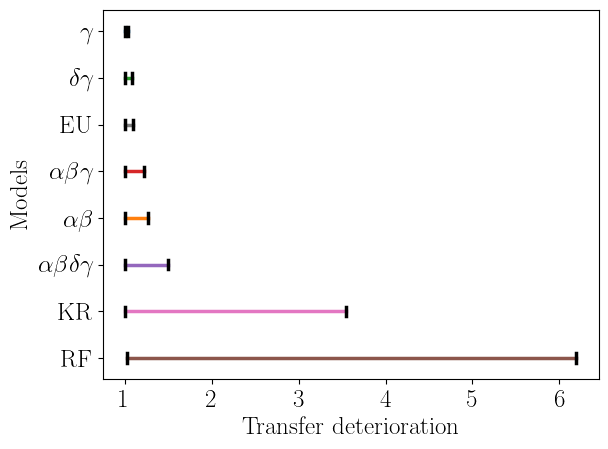

In [49]:
plot_intervals(all_models, raw_transfer_dic, lower_percent=lower_percent, higher_percent=higher_percent, keyword=transfer_error, x_scale=None, savepath=f'{fol}/{lower_percent}_{higher_percent}_interval_transfer_error.pdf')
plot_intervals(all_models, best_normalize_dic, lower_percent=lower_percent, higher_percent=higher_percent, keyword=normalized_transfer, x_scale=None, savepath=f'{fol}/{lower_percent}_{higher_percent}_interval_normalized_transfer_error.pdf')
plot_intervals(all_models, same_model_normalize_dic, lower_percent=lower_percent, higher_percent=higher_percent, keyword=same_model_transfer, x_scale=None, savepath=f'{fol}/{lower_percent}_{higher_percent}_interval_transfer_deterioration.pdf')

# plot_intervals(CPT_models, raw_transfer_dic, lower_percent=lower_percent, higher_percent=higher_percent, keyword=transfer_error, savepath=f'{fol}/CPT_{lower_percent}_{higher_percent}_interval_transfer_error.pdf')
# plot_intervals(CPT_models, best_normalize_dic, lower_percent=lower_percent, higher_percent=higher_percent, keyword=normalized_transfer, savepath=f'{fol}/CPT_{lower_percent}_{higher_percent}_interval_normalized_transfer_error.pdf')
# plot_intervals(CPT_models, same_model_normalize_dic, lower_percent=lower_percent, higher_percent=higher_percent, keyword=same_model_transfer, savepath=f'{fol}/CPT_{lower_percent}_{higher_percent}_interval_transfer_deterioration.pdf')